In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl

from matplotlib import style
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

stop_words = set(stopwords.words('english'))
style.use('ggplot')

In [2]:
quora_df = pd.read_csv('dataset/royal_family_quora_comments_dataset.csv')

In [3]:
quora_df.head()

,Quora Question,Reply/Comment,Classification,Label,Intensity
0,"If Prince Harry was not royalty, would Meghan ...",Pshhht please. This woman has never NOT dated ...,HS,1.0,1
1,NaN,No. She fell for a Prince. Not for Harry. If H...,HS,1.0,1
2,NaN,No she would not have married him. Megan sough...,HS,1.0,3
3,NaN,I agree 💯. Her ‘Is he nice’ line was to throw ...,HS,1.0,3
4,NaN,I noticed it too during the interview after th...,NHS,0.0,?


In [4]:
quora_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Quora Question  6 non-null      object 
 1   Reply/Comment   164 non-null    object 
 2   Classification  164 non-null    object 
 3   Label           164 non-null    float64
 4   Intensity       164 non-null    object 
dtypes: float64(1), object(4)
memory usage: 14.9+ KB


In [5]:
hate_speech_df = quora_df.iloc[:, 1:]
hate_speech_df.drop(columns=['Classification', 'Label'], inplace=True)
# print(hate_speech_df.isna().sum())

# Check for rows with NaN values and drop them
hate_speech_df.dropna(inplace=True)
hate_speech_df.head()

,Reply/Comment,Intensity
0,Pshhht please. This woman has never NOT dated ...,1
1,No. She fell for a Prince. Not for Harry. If H...,1
2,No she would not have married him. Megan sough...,3
3,I agree 💯. Her ‘Is he nice’ line was to throw ...,3
4,I noticed it too during the interview after th...,?


In [6]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'ð','',text)
    text = re.sub(r'\n','',text)
    # text = re.sub(r' ng | sa | na | ang | mga | ay | si | ni | ito | pa | rin | may | natin ',' ',text)
    # text = re.sub(r' nga | para | kay | kung | noon | mga | dahil | hindi | noong | mula ',' ',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [7]:
hate_speech_df['Reply/Comment'] = hate_speech_df['Reply/Comment'].apply(data_processing)
display(hate_speech_df.tail(10))
# display(hate_speech_df.head(10))




,Reply/Comment,Intensity
154,loved meghan joined royal family couldnt wait ...,3
155,majority dont like vermin gutter trash,3
156,whats little meghan lot psyche people needing ...,1
157,read people expressing desire meghans child ta...,1
158,many liars deceivers pretendersdo really like ...,1
159,sad pathetic individuals something lacking liv...,?
160,news first announced meghan engaged harry took...,?
161,prior engagement attractive mediocre actress c...,1
162,dont think matter like dislike think matter so...,1
163,im studying law knew meghan role suits wasnt a...,1


In [8]:

# Tokenize the text (split by whitespace)
words = hate_speech_df['Reply/Comment'].str.lower().str.split()

words_flat = [word for sublist in words for word in sublist]


# Count the occurrences of each word
word_counts = Counter(words_flat)

# Sort the words based on their frequencies
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame from the sorted word counts
df_word_counts = pd.DataFrame(sorted_word_counts, columns=['Word', 'Count'])

# Save the DataFrame to a CSV file
df_word_counts.to_csv('dataset/word_counts2.csv', index=False)




In [9]:
hate_speech_df = hate_speech_df.drop_duplicates('Reply/Comment')
# duplicate_rows = news_df.duplicated('Data')
# print("Number of duplicate rows:", duplicate_rows.sum())
# print(len(news_df))
display(hate_speech_df)

,Reply/Comment,Intensity
0,pshhht please woman never dated someone rich f...,1
1,fell prince harry harry man bus driver would s...,1
2,would married megan sought saw vulnerability t...,3
3,agree nice line throw everyone think sweet lit...,3
4,noticed interview became engaged rarely spoke ...,?
...,...,...
159,sad pathetic individuals something lacking liv...,?
160,news first announced meghan engaged harry took...,?
161,prior engagement attractive mediocre actress c...,1
162,dont think matter like dislike think matter so...,1


In [10]:
lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    tweet = [lemmatizer.lemmatize(word) for word in data.split()]
    return " ".join(tweet)


In [11]:
hate_speech_df['Reply/Comment'] = hate_speech_df['Reply/Comment'].apply(lambda x: lemmatizing(x))
display(hate_speech_df.head(10))


,Reply/Comment,Intensity
0,pshhht please woman never dated someone rich f...,1
1,fell prince harry harry man bus driver would s...,1
2,would married megan sought saw vulnerability t...,3
3,agree nice line throw everyone think sweet lit...,3
4,noticed interview became engaged rarely spoke ...,?
5,get surprise found money prince charles harry ...,?
6,kind thats care ffffffffffffff egg menu cant w...,1
7,well took time nice see real live american wok...,3
8,rachel meghan markle even know kate middleton ...,1
9,harry know marriage isnt going last he good ti...,1


In [12]:
hate_speech_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, 0 to 163
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Reply/Comment  163 non-null    object
 1   Intensity      163 non-null    object
dtypes: object(2)
memory usage: 3.8+ KB


In [13]:
hate_speech_df['Intensity'].value_counts()

Intensity
1    61
3    60
?    29
2    10
4     3
Name: count, dtype: int64

### Data visualization 

Text(0.5, 0, '')

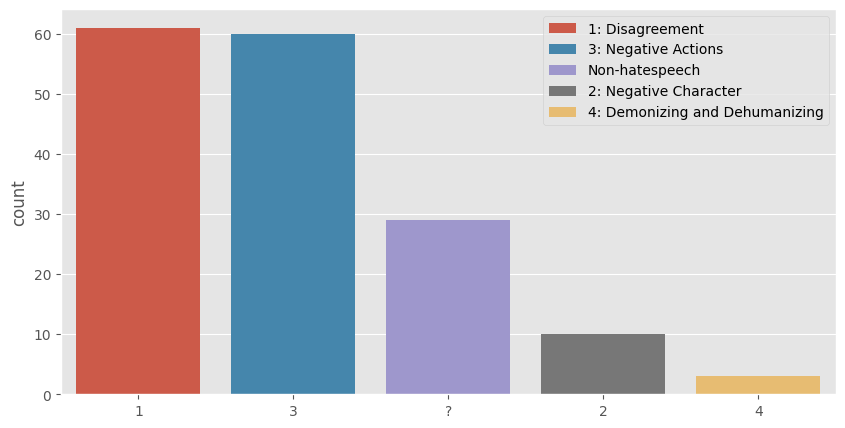

In [14]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='Intensity', hue="Intensity", dodge=False, data = hate_speech_df, order = hate_speech_df['Intensity'].value_counts().index)
plt.legend(labels = ['1: Disagreement', '3: Negative Actions', "Non-hatespeech" ,"2: Negative Character","4: Demonizing and Dehumanizing"])
plt.xlabel('')

Text(0.5, 1.0, 'Distribution of sentiments')

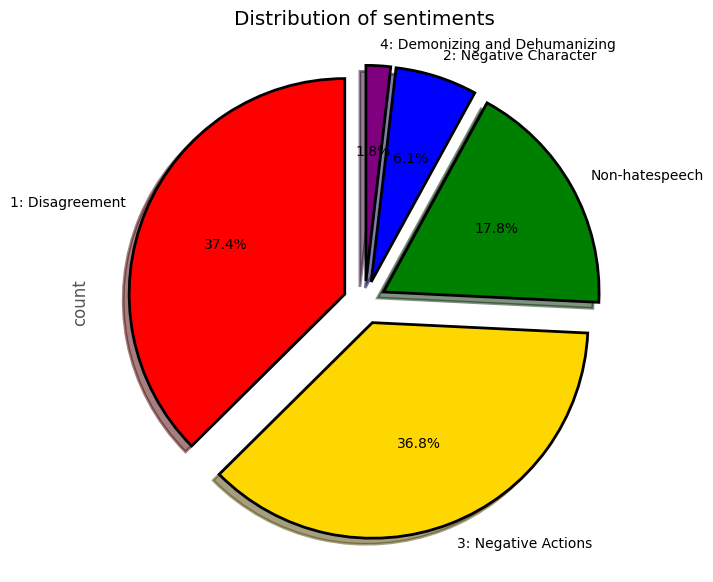

In [15]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold", "green", "blue", "purple")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = hate_speech_df['Intensity'].value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, startangle=90, 
          wedgeprops=wp, explode=explode, labels=['1: Disagreement', '3: Negative Actions', "Non-hatespeech", "2: Negative Character", "4: Demonizing and Dehumanizing"])
plt.title('Distribution of sentiments')


fig = plt.figure(figsize=(7,7))
colors = ["red", "gold", "green", "blue", "purple"]
wp = {'linewidth': 1, 'edgecolor': "black"}
tags = hate_speech_df['Intensity'].value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
plt.legend(labels = ['1: Disagreement', '3: Negative Actions', "Non-hatespeech" ,"2: Negative Character","4: Demonizing and Dehumanizing"])

plt.title('Distribution of sentiments')

In [16]:
from sklearn.preprocessing import LabelEncoder
labelEncoder_y = LabelEncoder()
hate_speech_df['Intensity'] = labelEncoder_y.fit_transform(hate_speech_df['Intensity'])        
display(hate_speech_df.head(10))

,Reply/Comment,Intensity
0,pshhht please woman never dated someone rich f...,0
1,fell prince harry harry man bus driver would s...,0
2,would married megan sought saw vulnerability t...,2
3,agree nice line throw everyone think sweet lit...,2
4,noticed interview became engaged rarely spoke ...,4
5,get surprise found money prince charles harry ...,4
6,kind thats care ffffffffffffff egg menu cant w...,0
7,well took time nice see real live american wok...,2
8,rachel meghan markle even know kate middleton ...,0
9,harry know marriage isnt going last he good ti...,0


In [17]:
hate_speech = hate_speech_df[hate_speech_df['Intensity'].isin([0, 1, 2, 3])]
hate_speech.head(10)

,Reply/Comment,Intensity
0,pshhht please woman never dated someone rich f...,0
1,fell prince harry harry man bus driver would s...,0
2,would married megan sought saw vulnerability t...,2
3,agree nice line throw everyone think sweet lit...,2
6,kind thats care ffffffffffffff egg menu cant w...,0
7,well took time nice see real live american wok...,2
8,rachel meghan markle even know kate middleton ...,0
9,harry know marriage isnt going last he good ti...,0
10,totally true,0
19,much deplorable liar,2


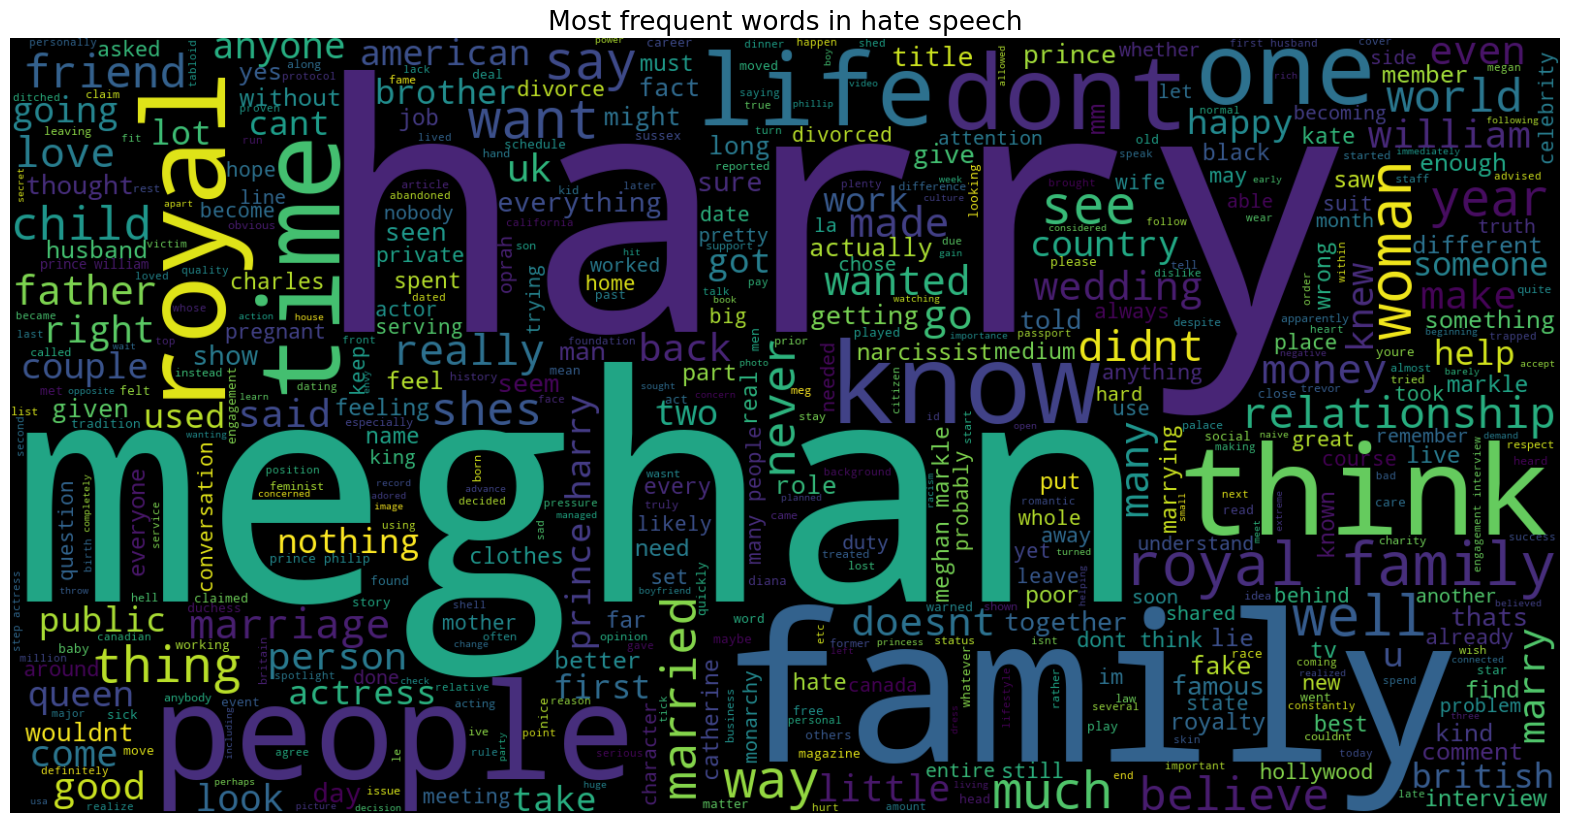

In [18]:
text = ' '.join([word for word in hate_speech['Reply/Comment']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in hate speech', fontsize = 19)
plt.show()

In [19]:
non_hate_speech = hate_speech_df[hate_speech_df.Intensity == 4]
non_hate_speech.head(10)

,Reply/Comment,Intensity
4,noticed interview became engaged rarely spoke ...,4
5,get surprise found money prince charles harry ...,4
11,agree think harry finally woken really,4
12,totally trapped marriage,4
13,done complete background check someone would r...,4
14,fought britain dont think matures man created ...,4
15,yes true wrote susan agree katherine born exce...,4
16,one thousand percent correct youre comment kat...,4
17,course harry penniless pauper would married love,4
18,lol,4


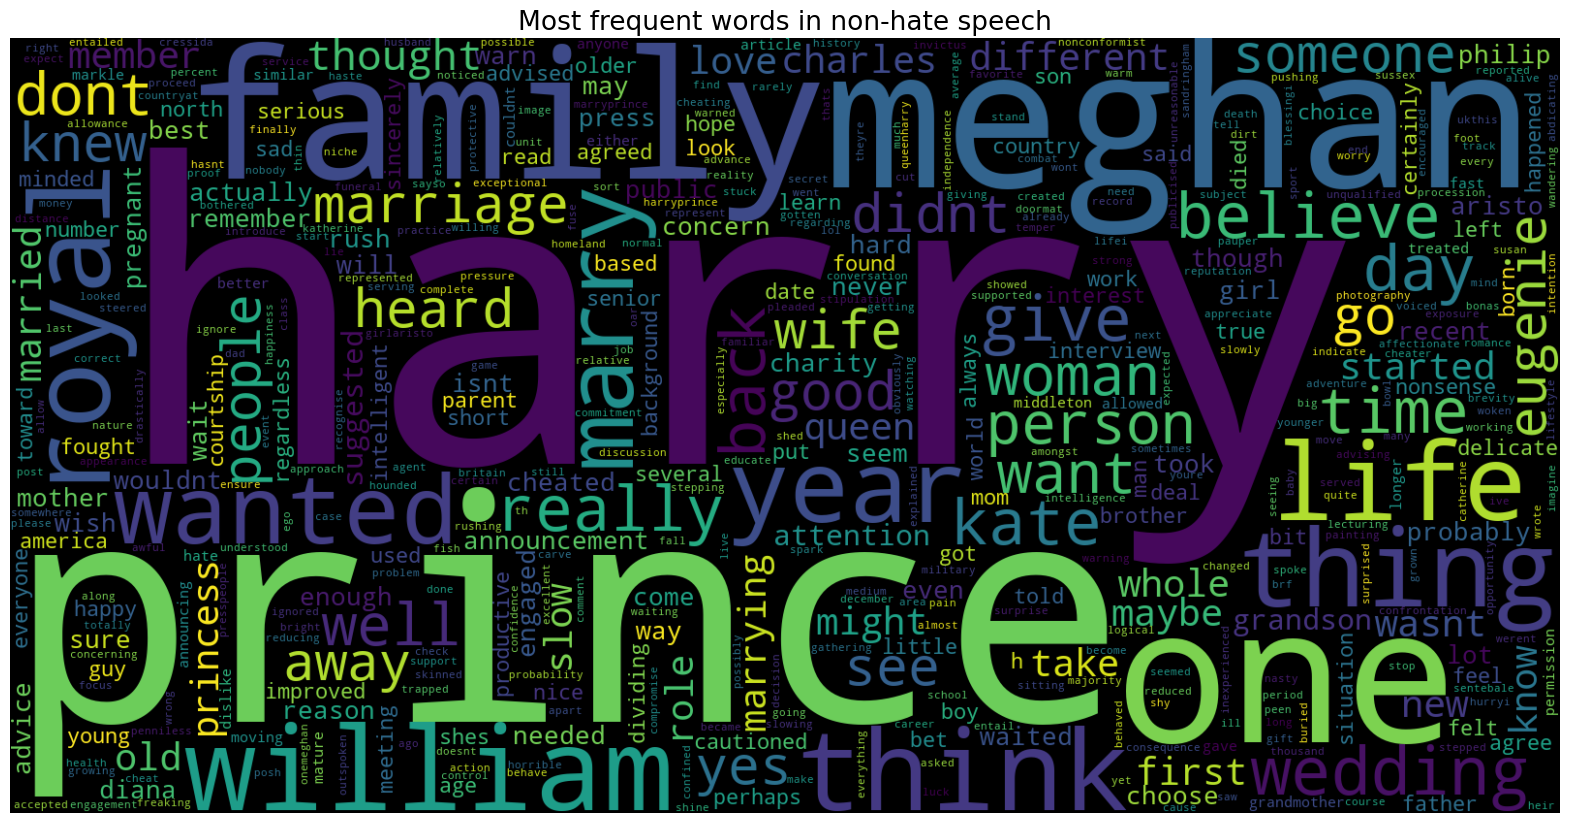

In [20]:
text = ' '.join([word for word in non_hate_speech['Reply/Comment']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in non-hate speech', fontsize = 19)
plt.show()

In [21]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(hate_speech_df['Reply/Comment'])

In [22]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 13579

First 20 features: 
['10' '10 year' '100' '100 money' '100 theyve' '100 think' '100 year'
 '1000' '1000 year' '10th' '10th grade' '11' '11 ouchmeghan' '12'
 '12 year' '15' '15 minutesmegs' '15 year' '18' '18 month']


In [23]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit(hate_speech_df['Reply/Comment'])

In [52]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[40:60]))

Number of features: 24204

First 20 features: 
['1993' '1993 drastically' '1993 drastically reduced' '20' '20 minute'
 '20 minute since' '2013' '2013 meghan' '2013 meghan lot' '2015'
 '2015 fake' '2015 fake tear' '2015 video' '2015 video saying' '2017'
 '2017 made' '2017 made feel' '20172019' '20172019 harry'
 '20172019 harry prince']


## Model Building

In [25]:
X = hate_speech_df['Reply/Comment']
Y = hate_speech_df['Intensity']
X = vect.transform(X)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)


In [27]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))


Size of x_train: (130, 24204)
Size of y_train: (130,)
Size of x_test:  (33, 24204)
Size of y_test:  (33,)


In [72]:
import sys
def train_model(model_type, model_class, data_dict, is_grid_search, param_grid):
    
    if is_grid_search:
        model_type = f"{model_type} Base Model"

    y_train = data_dict.get("y_train")
    x_train = data_dict.get("x_train")
    x_test = data_dict.get("x_test")
    X = data_dict.get("X")
    Y = data_dict.get("Y")
    
    try: 
        model_class.fit(x_train, y_train)
        y_predict = model_class.predict(x_test)

    except Exception as e:
        model_class.fit(x_train.toarray(), y_train)
        y_predict = model_class.predict(x_test.toarray())


    # Saving the confusion matrix as a graph to "output"
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})  # Increase font size for annotations
    plt.xlabel('Predicted', fontsize=14)  # Increase font size for x-axis label
    plt.ylabel('Truth', fontsize=14)  # Increase font size for y-axis label
    plt.title(f'Confusion Matrix for {model_type}', fontsize=18)  # Increase font size for title
    plt.savefig(f"output/{model_type}_confusion.png")
    plt.close()

    classification_accuracy = accuracy_score(y_test, y_predict)
    classification_report_dict = classification_report(y_test, y_predict, digits=4, output_dict=True)
    classification_report_df = pd.DataFrame(classification_report_dict).transpose()
    classification_report_df.to_excel(f"output/{model_type}_classification_report.xlsx")

    k_fold = KFold(n_splits=10)

    accuracies = cross_val_score(estimator=model_class, X=X.toarray(), y=Y, cv=k_fold, scoring='accuracy')
    plt.figure(figsize=(10, 7))
    sns.boxplot(data=accuracies).set_title(f'Cross-Validation Accuracy Scores for {model_type}')
    plt.xticks(ticks=range(10), labels=[f'Fold {i+1}' for i in range(10)])
    plt.savefig(f"output/{model_type}_boxplot.png")
    plt.close()
    
    accuracies_average = accuracies.mean()
    accuracies_variance = accuracies.std()

    try:
        auc_val = roc_auc_score(y_test, model_class.predict_proba(x_test), multi_class='ovr')
    except Exception as e:
        auc_val = roc_auc_score(y_test, model_class.predict_proba(x_test.toarray()), multi_class='ovr')

    # Store metrics in a DataFrame and save as an Excel file
    metrics_df = pd.DataFrame({
        'Accuracy': [classification_accuracy],
        'AUC': [auc_val],
        'Cross-Validation Accuracies': [accuracies],
        'Cross-Validation Mean Accuracy': [accuracies_average],
        'Cross-Validation Accuracy Std Dev': [accuracies_variance],
        # "classification_report": classification_report_dict
    })
    metrics_df.to_excel(f"output/{model_type}_performance_metrics.xlsx", index=False)
    # sys.exit(0)
    # if is_grid_search:
    #     print(f"{model_type} grid searching...")
    #     grid = GridSearchCV(model_class, param_grid, cv=5)
    #     try:
    #         grid.fit(x_train, y_train)
    #     except Exception as e:
    #         grid.fit(x_train.toarray(), y_train)

    #     print(model_type, "Best Cross-validation score for: {:.2f}".format(grid.best_score_))
    #     print("Best parameters: ", grid.best_params_)

In [73]:
data_dict ={
    "y_train":  y_train,
    "x_train":  x_train,
    "x_test":   x_test,
    "X":        X,
    "Y":        Y
}
random_forest_classifier = RandomForestClassifier()
param_grid = {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'random_state': [0, 42, 3, 6]}
train_model(model_type = "Random Forest", model_class = random_forest_classifier, data_dict = data_dict, is_grid_search = True, param_grid = param_grid)

gaussian_naive_bayes = GaussianNB()
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'priors': [None, [0.5, 0.5], [0.4, 0.6], [0.6, 0.4]],
}
train_model(model_type = "Naive Bayes", model_class = gaussian_naive_bayes, data_dict = data_dict, is_grid_search = True, param_grid = param_grid)


support_vector_machine = SVC(probability=True)
param_grid = {'C': [100, 10, 1.0, 0.1, 0.01], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'random_state': [0, 42, 3, 6]}
train_model(model_type = "Support Vector Machine", model_class = support_vector_machine, data_dict = data_dict, is_grid_search = True, param_grid = param_grid)



In [74]:
random_forest_classifier = RandomForestClassifier(max_depth=20, min_samples_leaf = 1, min_samples_split = 10, n_estimators = 10, random_state=3)
param_grid = {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'random_state': [0, 42, 3, 6]}
train_model(model_type = "Random Forest", model_class = random_forest_classifier, data_dict = data_dict, is_grid_search = False, param_grid = param_grid)

gaussian_naive_bayes = GaussianNB(priors = None, var_smoothing = 1e-09)
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'priors': [None, [0.5, 0.5], [0.4, 0.6], [0.6, 0.4]],
}
train_model(model_type = "Naive Bayes", model_class = gaussian_naive_bayes, data_dict = data_dict, is_grid_search = False, param_grid = param_grid)


support_vector_machine = SVC(C = 100, kernel = "sigmoid", random_state = 0, probability=True)
param_grid = {'C': [100, 10, 1.0, 0.1, 0.01], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'random_state': [0, 42, 3, 6]}
train_model(model_type = "Support Vector Machine", model_class = support_vector_machine, data_dict = data_dict, is_grid_search = False, param_grid = param_grid)

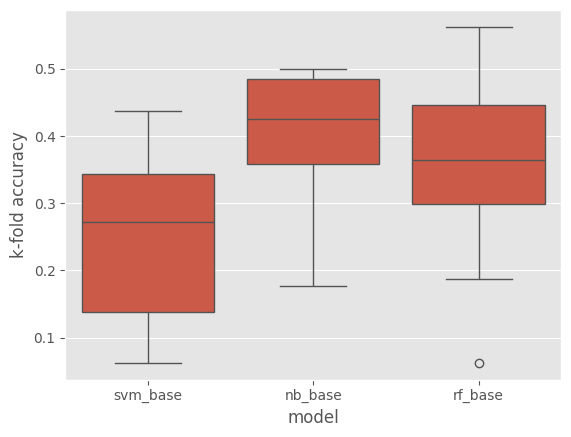

In [67]:
svm_base = [0.17647059, 0.35294118, 0.29411765, 0.125, 0.125, 0.3125, 0.25, 0.4375, 0.0625, 0.4375]
nb_base = [0.17647059, 0.35294118, 0.41176471, 0.3125, 0.375, 0.5, 0.5, 0.4375, 0.4375, 0.5]
rf_base = [0.35294118, 0.29411765, 0.47058824, 0.375, 0.375, 0.5, 0.1875, 0.5625, 0.0625, 0.3125]

svm_df = pd.DataFrame({'model': ['svm_base'] * len(svm_base), 'k-fold accuracy': svm_base})
nb_df = pd.DataFrame({'model': ['nb_base'] * len(nb_base), 'k-fold accuracy': nb_base})
rf_df = pd.DataFrame({'model': ['rf_base'] * len(rf_base), 'k-fold accuracy': rf_base})

# Concatenate all dataframes into a single dataframe
base_kfold_accuracy_df = pd.concat([svm_df, nb_df, rf_df], ignore_index=True)
# Create a boxplot of k-fold accuracies for each model
sns.boxplot(x='model', y='k-fold accuracy', data=base_kfold_accuracy_df)
plt.savefig('output/base_boxplot.png')


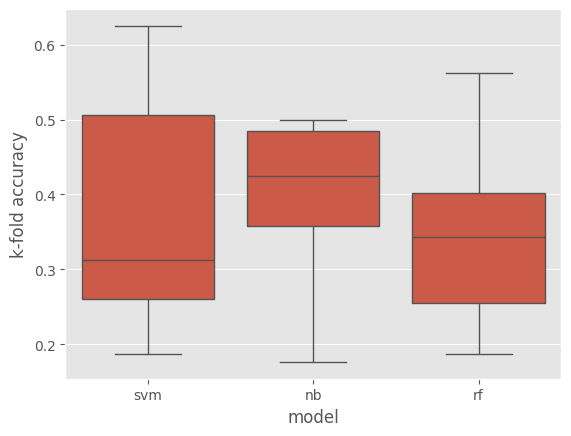

In [69]:
svm_base = [0.29411765, 0.23529412, 0.52941176, 0.3125, 0.3125, 0.5625, 0.25, 0.625, 0.1875, 0.4375]
nb_base = [0.17647059, 0.35294118, 0.41176471, 0.3125, 0.375, 0.5, 0.5, 0.4375, 0.4375, 0.5]
rf_base = [0.23529412, 0.23529412, 0.41176471, 0.375, 0.375, 0.5625, 0.3125, 0.5625, 0.1875, 0.3125]

svm_df = pd.DataFrame({'model': ['svm'] * len(svm_base), 'k-fold accuracy': svm_base})
nb_df = pd.DataFrame({'model': ['nb'] * len(nb_base), 'k-fold accuracy': nb_base})
rf_df = pd.DataFrame({'model': ['rf'] * len(rf_base), 'k-fold accuracy': rf_base})

# Concatenate all dataframes into a single dataframe
base_kfold_accuracy_df = pd.concat([svm_df, nb_df, rf_df], ignore_index=True)
# Create a boxplot of k-fold accuracies for each model
sns.boxplot(x='model', y='k-fold accuracy', data=base_kfold_accuracy_df)
plt.savefig('output/tuned_boxplot.png')

   Classification  precision    recall  f1-score
0               0   0.250000  0.083333  0.125000
1               1   0.000000  0.000000  0.000000
2               2   0.392857  0.916667  0.550000
3               3   0.000000  0.000000  0.000000
4               4   0.000000  0.000000  0.000000
5               0   0.368421  0.583333  0.451613
6               1   0.000000  0.000000  0.000000
7               2   0.625000  0.416667  0.500000
8               3   0.000000  0.000000  0.000000
9               4   0.166667  0.166667  0.166667
10              0   0.363636  1.000000  0.533333
11              1   0.000000  0.000000  0.000000
12              2   0.000000  0.000000  0.000000
13              3   0.000000  0.000000  0.000000
14              4   0.000000  0.000000  0.000000


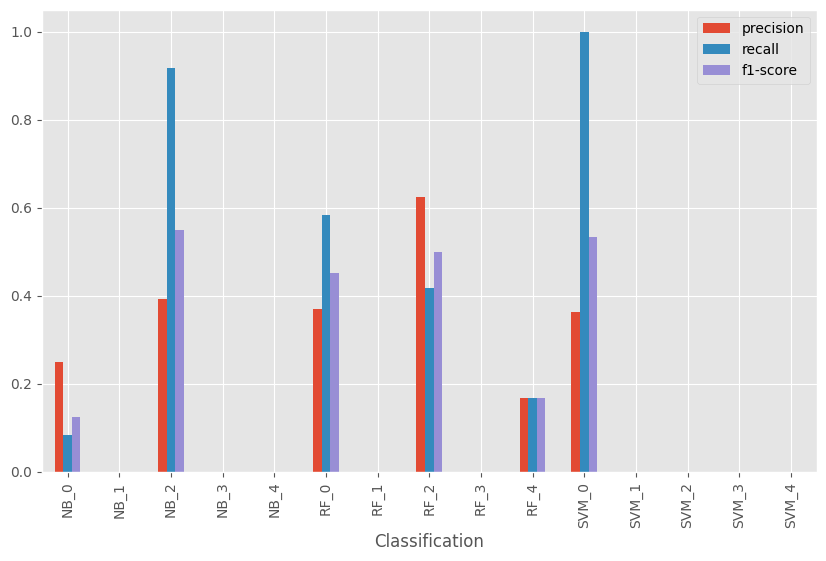

<Figure size 640x480 with 0 Axes>

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel files
file1 = pd.read_excel('output/Naive Bayes Base Model_classification_report.xlsx')
file2 = pd.read_excel('output/Random Forest Base Model_classification_report.xlsx')
file3 = pd.read_excel('output/Support Vector Machine Base Model_classification_report.xlsx')
# Filter out the rows with 'accuracy', 'macro avg', 'weighted avg', and 'support'
exclusion_criteria = 'accuracy|macro avg|weighted avg'
file1 = file1[~file1['Unnamed: 0'].str.contains(exclusion_criteria, na=False)]
file2 = file2[~file2['Unnamed: 0'].str.contains(exclusion_criteria, na=False)]
file3 = file3[~file3['Unnamed: 0'].str.contains(exclusion_criteria, na=False)]

# Merge the dataframes on a common column if necessary, here we assume they have the same structure
merged_df = pd.concat([file1, file2, file3], ignore_index=True)
merged_df.rename(columns={'Unnamed: 0': 'Classification'}, inplace=True)
merged_df.pop('support')

print(merged_df)

# Rename 'Unnamed: 0' column with NB_0, RF_0, SVM_0, etc.
model_prefixes = ['NB_', 'RF_', 'SVM_']
for i, prefix in enumerate(model_prefixes):
    start_index = i * len(file1)
    end_index = (i + 1) * len(file1)
    merged_df.loc[start_index:end_index-1, 'Classification'] = [prefix + str(idx) for idx in range(len(file1))]

merged_df.plot(kind='bar', x='Classification', y=['precision', 'recall', 'f1-score'], figsize=(10, 6))
plt.show()



# Save the plot
plt.savefig('output/base_comparison_bar_plot.png')
plt.show()



   Classification  precision    recall  f1-score
0               0   0.250000  0.083333  0.125000
1               1   0.000000  0.000000  0.000000
2               2   0.392857  0.916667  0.550000
3               3   0.000000  0.000000  0.000000
4               4   0.000000  0.000000  0.000000
5               0   0.380952  0.666667  0.484848
6               1   0.000000  0.000000  0.000000
7               2   0.416667  0.416667  0.416667
8               3   0.000000  0.000000  0.000000
9               4   0.000000  0.000000  0.000000
10              0   0.545455  0.500000  0.521739
11              1   0.000000  0.000000  0.000000
12              2   0.523810  0.916667  0.666667
13              3   0.000000  0.000000  0.000000
14              4   0.000000  0.000000  0.000000


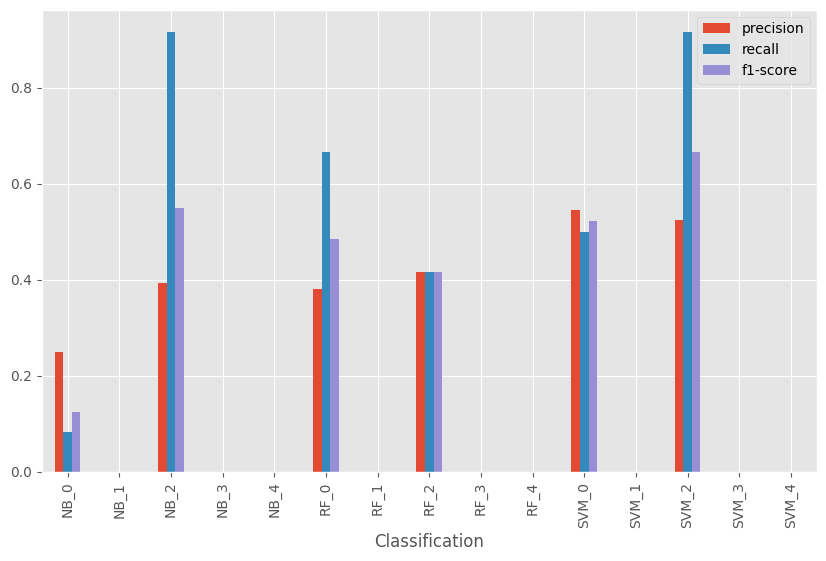

<Figure size 640x480 with 0 Axes>

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel files
file1 = pd.read_excel('output/Naive Bayes_classification_report.xlsx')
file2 = pd.read_excel('output/Random Forest_classification_report.xlsx')
file3 = pd.read_excel('output/Support Vector Machine_classification_report.xlsx')
# Filter out the rows with 'accuracy', 'macro avg', 'weighted avg', and 'support'
exclusion_criteria = 'accuracy|macro avg|weighted avg'
file1 = file1[~file1['Unnamed: 0'].str.contains(exclusion_criteria, na=False)]
file2 = file2[~file2['Unnamed: 0'].str.contains(exclusion_criteria, na=False)]
file3 = file3[~file3['Unnamed: 0'].str.contains(exclusion_criteria, na=False)]

# Merge the dataframes on a common column if necessary, here we assume they have the same structure
merged_df = pd.concat([file1, file2, file3], ignore_index=True)
merged_df.drop(columns='support', inplace=True)
merged_df.rename(columns={'Unnamed: 0': 'Classification'}, inplace=True)

print(merged_df)

# Rename 'Unnamed: 0' column with NB_0, RF_0, SVM_0, etc.
model_prefixes = ['NB_', 'RF_', 'SVM_']
for i, prefix in enumerate(model_prefixes):
    start_index = i * len(file1)
    end_index = (i + 1) * len(file1)
    merged_df.loc[start_index:end_index-1, 'Classification'] = [prefix + str(idx) for idx in range(len(file1))]

merged_df.plot(kind='bar', x='Classification', y=['precision', 'recall', 'f1-score'], figsize=(10, 6))
plt.show()



# Save the plot
plt.savefig('output/tuned_comparison_bar_plot.png')
plt.show()



In [ ]:
##END##